# Naive bayesian decoder
Generative classifiers

Conditional probabilities

Tuning curves to probabilities

Bayes rule

Naive bayes classifier with numpy

Naive bayes classifier with sklearn

Noise correlation and normalization



In [80]:
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from source.spikes import spikes_to_df, rf
from source.utils import poisson_pdf

## Generative vs. discriminative classifiers

So far we have used logistic regression classifiers to do our decoding. These take a set of features and use them to predict the probability of the event class that generated it. 

## Conditional probability

We already mentioned conditional probabilities when discussing how to interpret the logistic function. In that case, the logisitic function reflects the probability of a certain event occurring given the features in our data, $p(y|x)$, where $y$ is the event and $x$ are the features. Across all possible classes there will be a different $p(y_k|x)$, and the sum of those probabilities across all possible classes will be 1:

$$ \sum_{k=1}^{K}{p(y_k|x)} = 1 $$

When evaluating the probability across all classes, the $x$ is kept constant. 

The general way to express conditional probability is:

$$ p(y|x) = \frac{p(y,x)}{p(x)} \tag{eq. 1} $$

Here $p(y,x)$ is the probability that particular instances of $y$ and $x$ ever co-occur. If we divide that by the probability of $x$ occurring, $p(x)$, then we have the probability of $y$ *conditional* on $x$. That is, it is the probability of $y$ for all instances when $x$ is of a particular value.

When $y$ and $x$ are conditionally independent of one another then $p(y|x)=p(y)p(x)$. This just means that the chance $y$ occurring with $x$ will equal to the probability that either of those happen in general (irrespective of each other). This is what is meant by conditional independence. 



## Bayes' theorem

Given equation 1 and a little algebra, we can establish a fundamental relationship between conditional probabilities known as Bayes' rule or theorem. Note that swapping $x$ and $y$, we get the equation $p(x|y)=\frac{p(x,y)}{p(y)}$, which can be rearranged to $p(x|y)p(y)=p(x,y)$. Also note that $p(y,x) = p(x,y)$. With these facts, we can write:

$$ \begin{align}
    p(y|x)p(x) &= p(y,x) = p(x,y) = p(x|y)p(y) \notag \\
    p(y|x)p(x) &= p(x|y)p(y) \notag \\
    p(y|x) &= \frac{p(x|y)p(y)}{p(x)} \tag{2} \\
    \end{align}
$$

This powerful relationship shows how to go from the conditional probability of $x$ given $y$, to that of $y$ given $x$. 

Why is this relaiontship important? Returning to decoders, their goal is to estimate the probability of behavioral or stimulus events, $y_k$, given patterns in brain activity, $x$. In the previous lectures we estimated this probability, $p(y_k|x)$ using logistic regression. The event $k$ with the largest probability was then chosen as the one most likely to have occured. However, Bayes' theorem offers an alternative approach. Instead we can derive that by measuring the probability of observing our brain data given that event $y_k$ occured and use that, along with our knowledge about how often $y_k$ occurs.

Bayes' theorem is so prominent that each term in it has a name:
1. $p(y|x)$ is the *posterior*. This is the probability of an event given the brain data.
2. $p(x|y)$ is the *likelihood*. This is the probability of the brain data given an event.
3. $p(y)$ is the *prior*. This is the probability of an event occuring.
4. $p(x)$ is the *evidence*. This is the probability of the observed brain data occuring.

Both the likelihood and prior can be determined from the data we have been working with so far. Less tractable is an estimate of the evidence, the probability of the brain data, because that would require us to observe all possible brain states. Fortunately, with classification we just want the event with the highest probability, and do not care about its *actual* probability. For a given decoding estimate we, we want to estimate $p(y|x)$ for a certain brain state we observed, $x$. This means that the $p(x)$ in Bayes' rule will be held constant across all possible events, $y_k$. Thus, while we do not know the exact value of $p(x)$, it is just rescaling the values of $p(y|x)$. This will not change which $y_k$ is highest or lowest, so leaving it out has no impact on our ability to classify. As a result, for our decoder can use the following rule:

$$ \text{selection} = \arg\max_{y_k}p(x|y)p(y) $$

Let's give this a try with a single neuron from the Allen Institute data set.

## Bayes' theorem and the single neuron

To start, we will load in the neurons from last week and select one with well defined tuning for orientation.

In [2]:
# initialize data cache
allen_dir = ['..','data','spike_allen']
manifest_path = os.path.join(*allen_dir,'manifest.json')
cache = EcephysProjectCache(manifest=manifest_path)

# get session
sess_id = 750332458
sess = cache.get_session_data(sess_id, filter_by_validity=False)
stims = sess.stimulus_presentations

# get the ids of the units that passed quality control last week
# save as an numpy file where the Allen cache is stored
ids_path = os.path.join(*allen_dir,'clean_unit_ids.npy')
unit_ids = np.load(ids_path)

# get stimulus presentations
dg_stims = stims[stims['stimulus_name'] == 'drifting_gratings']
dg_stims = dg_stims[(dg_stims['contrast']!='null') |
                    (dg_stims['spatial_frequency']!='null') |
                    (dg_stims['orientation']!='null') |
                    (dg_stims['temporal_frequency']!='null')]

# get the spike times as a dataframe
spikes = spikes_to_df(sess)

# keep only those rows whose index is in unit_ids
spikes = spikes[spikes.index.isin(unit_ids)]

# compute orientation RF for each unit
spikes['rf_ori'] = spikes['times'].apply(
    lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['orientation']))

# get the empirical orientation tuning curve
spikes['rf_ori_emp'] = spikes['rf_ori'].apply(lambda x: x.rf())

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [3]:
sel_unit = 951815599
rf_ori_counts = spikes.loc[sel_unit,'rf_ori'].stim_counts
rf_ori_mean = spikes.loc[sel_unit,'rf_ori_emp']
ori_vals = rf_ori_mean[2][0]

Text(0.5, 1.0, 'Orientation tuning curve for unit 951815599')

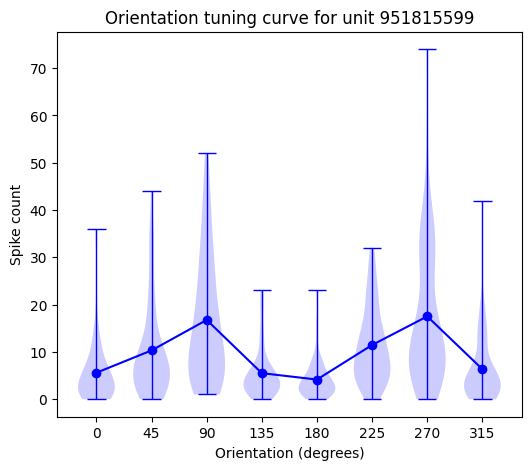

In [56]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(ori_vals, rf_ori_mean[0].flatten(), 'o-', color='blue')


for ori, counts in rf_ori_counts.iterrows():
    vp = ax.violinplot(counts.values[0], positions=[ori], widths=30)
    vp['bodies'][0].set_facecolor('blue')
    vp['bodies'][0].set_alpha(0.2)
    for line in ['cmaxes', 'cmins', 'cbars']:
        vp[line].set_edgecolor('blue')
        vp[line].set_linewidth(1)
ax.set_xticks(ori_vals)
ax.set_xlabel('Orientation (degrees)')
ax.set_ylabel('Spike count')
ax.set_title('Orientation tuning curve for unit {}'.format(sel_unit))

An alternative way to visualize this is the probability of observing some spike count, $x$, and and orientation, $y$. This is expressed as $p(x,y)$.

We can do this by counting the number of times each number of spike counts occured for each orientation and placing that into an array. The rows will be the spike counts and the columns the orientations. This is just another example of binning. In previous lectures we binned spike times across time by counting the number of spikes in small intervals of time. That is, we grouped spike together that fell in a time window and counted here. Here, we are grouping trials based on the orientation presented and number of spikes that occured in response. 

To convert this to a probability, we divide the count in each bin by the total number of counts.

In [5]:
# range of values to bin over
num_stim = rf_ori_counts.shape[0] # number of stimuli
max_counts = int(rf_ori_counts['spike_counts'].apply(lambda x: x.max()).max()) # max spike count

# joint distribution of spike counts
joint_dist = np.zeros((max_counts+1, num_stim))
for i, (_, counts) in enumerate(rf_ori_counts.iterrows()):
    joint_dist[:,i] = np.histogram(counts.values[0], bins=np.arange(max_counts+2))[0]

# normalize by the total number of counts
joint_dist = joint_dist / joint_dist.sum()

# grid of joint distribution points
x, y = np.meshgrid(np.append(ori_vals, 360), np.arange(max_counts+2))

Text(0.5, 1.0, 'Joint probability distribution of spike counts and orientation')

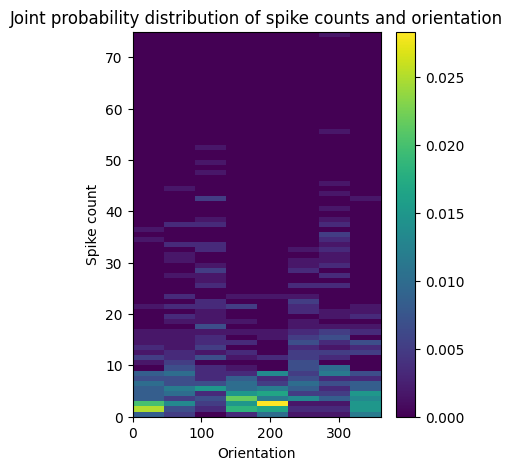

In [6]:
fig, ax = plt.subplots(figsize=(4,5))
ax.pcolormesh(x, y, joint_dist)
fig.colorbar(ax=ax, mappable=ax.collections[0])
ax.set_xlabel('Orientation')
ax.set_ylabel('Spike count')
ax.set_title('Joint probability distribution of spike counts and orientation')

Notice that the probabitliies are not smooth but spotty and sometimes have gaps between them. This becomes easily seen if we color white those bins with 0 counts.

Text(0.5, 1.0, 'Joint probability distribution of spike counts and orientation')

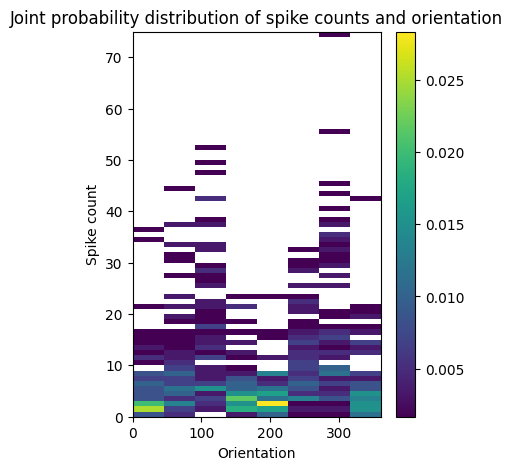

In [7]:
# remove zeros for better visualization
joint_dist_nan = joint_dist.copy()
joint_dist_nan[joint_dist_nan==0] = np.nan

fig, ax = plt.subplots(figsize=(4,5))
ax.pcolormesh(x,y,joint_dist_nan)
fig.colorbar(ax=ax, mappable=ax.collections[0])
ax.set_xlabel('Orientation')
ax.set_ylabel('Spike count')
ax.set_title('Joint probability distribution of spike counts and orientation')

Here we have some combinations of orientation and spike count that never occurred, and so they are given a probability of 0. For instance, there were no trials with an orientation of 45 degrees that had 17 spikes. But, there were trials when 45 degree oriented gratings were presented that had 16 or 18 spikes. 

In [8]:
print('Orientation of 45 degrees and spike count of 16: {:.3f} probability'.format(joint_dist[16,1]))
print('Orientation of 45 degrees and spike count of 17: {:.3f} probability'.format(joint_dist[17,1]))
print('Orientation of 45 degrees and spike count of 18: {:.3f} probability'.format(joint_dist[18,1]))

Orientation of 45 degrees and spike count of 16: 0.002 probability
Orientation of 45 degrees and spike count of 17: 0.000 probability
Orientation of 45 degrees and spike count of 18: 0.002 probability


This sparsity is, most likely, because we have only a finite number of trials to sample a neuron's response. This means our joint probability distribution will not be smooth. 

So now you might be wondering: Why is this a problem? If something never occurred, then shouldn't it have a probability of 0? Well, imagine we had only given a single presentation of each orientation, and constructed our joint probability distribution from that. In that case, we would only have one bin filled in for each orientation column, with the rest being 0. This extreme sparseness is because we did not sample the neuron's responses sufficiently. To overcome this, we would increase the number of trials. In theory, if we gave an infinite number of trials, we would expect a smooth joint probability distribution with no missing spots. 

Since it is impossible to give an infinite number of trials, we will instead fit a curve to the neuron's reponse to each stimulus. That curve will give an estimate of the neuron's response that is continuous. The challenge now is to choose the curve we want to use. In the last lecture we discussed how neuronal spike counts follow a poisson distribution, and fit a curve to those. We can do the same thing here, fitting the poisson response curve to each orientation.

To calculate the poisson probability distribution, $p(x) = \frac{\lambda^xe^{-x}}{x!}$, we only need to specify one parameter, $\lambda$, which is the mean value of the distribution. For our case here, that will be the mean spike count for each orientation. For the poisson distribution function we will call the `poisson_pdf` function we created last week.

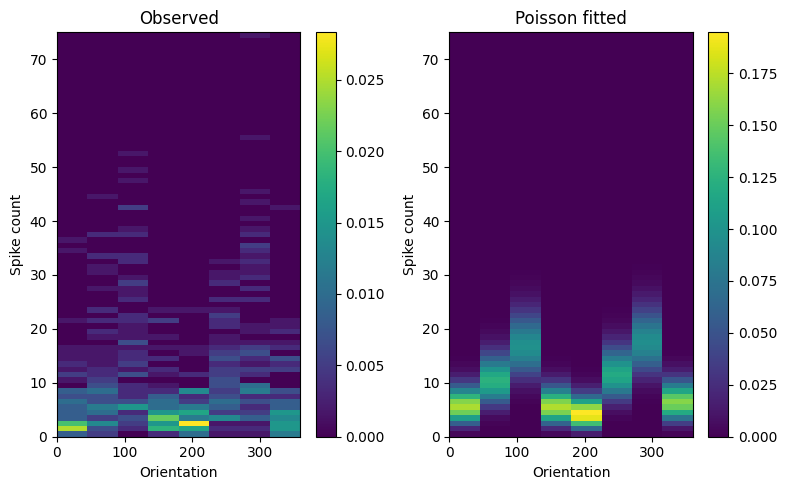

In [18]:
# fit a Poisson distribution based on the mean spike counts for each orientation
p_xgy_pois = np.zeros((max_counts+1, num_stim))
for i in range(num_stim):
    p_xgy_pois[:,i] = poisson_pdf(np.arange(max_counts+1), rf_ori_mean[0][i])

# plot the joint distribution and the Poisson fit
fig, ax = plt.subplots(1,2,figsize=(8,5))
ax[0].pcolormesh(x, y, joint_dist)
fig.colorbar(ax=ax[0], mappable=ax[0].collections[0])
ax[0].set_xlabel('Orientation')
ax[0].set_ylabel('Spike count')
ax[0].set_title('Observed')

ax[1].pcolormesh(x, y, p_xgy_pois)
fig.colorbar(ax=ax[1], mappable=ax[1].collections[0])
ax[1].set_xlabel('Orientation')
ax[1].set_ylabel('Spike count')
ax[1].set_title('Poisson fitted')

fig.tight_layout()

The match is not perfect. Our poisson distribution probabilities are generally larger than those of the observed joint distribution. This is because when we calculate the poisson probability for each orientation seperately, we are really calculating $p(x|y)$, which is a conditional probability. With a conditional probability the sum of $p(x|y)$ across all values of $x$ must equal 1.

You may also have noticed that the poisson distribution generally tends to be more concentrated around the mean spike count, with the observed distribution showing greater spread. This can be seen clearly if we plot the distribution for a single orientation. To do this, we will convert the fitted distribution which is conditional on $y$ to the joint probability, using $p(x,y)=p(x|y)p(y)$. It is easy to calculate $p(y)$ by just counting the number of trials for each orientation, and dividing by the total number of trials. We can use the observed joint probability distribution for that.

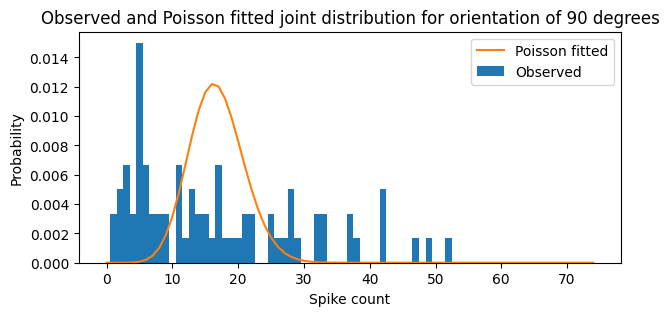

In [19]:
# calculate probability of each orientation being presented
p_y = joint_dist.sum(axis=0) / joint_dist.sum()

# calculate the joint distribution of spike counts and orientation 
# based on the Poisson fit
p_xy_pois = p_xgy_pois * p_y

fig, ax = plt.subplots(figsize=(7,3))
ax.bar(np.arange(max_counts+1), joint_dist[:,2], 1, label='Observed')
ax.plot(np.arange(max_counts+1), p_xy_pois[:,2], color='tab:orange', label='Poisson fitted')
ax.set_xlabel('Spike count')
ax.set_ylabel('Probability')
ax.set_title('Observed and Poisson fitted joint distribution for orientation of 90 degrees')
ax.legend()

Plotting the observed and fitted distributions this way lays bear the problem with assuming a Poisson fit. Nevertheless, it might be good enough for the purpose of decoding which orientation was presented based on the spike count, $p(y|x)$. Since we are using Bayes' rule, we know that $p(y|x) \propto p(x|y)p(y)$. Thus, we can use the joint probability of the fitted distribution we just calculated, `p_xy_pois`, to determine the most likely stimulus for a given spike count.

Let's range over the various spike counts that were recorded and return the orientation that was most likely for each based on `p_xy_pois`.

Text(0.5, 1.0, 'Predicted orientation based on spike count')

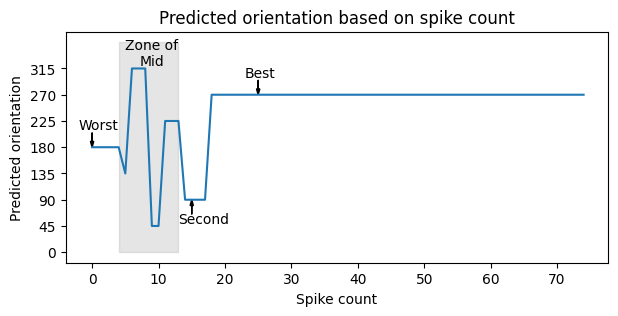

In [78]:
# initialize the spike counts and predicted orientations
spk_counts = np.arange(max_counts+1)
pred_ori = np.zeros(spk_counts.shape)

# predict the orientation based on the spike count using p(x|y) * p(y)
nb_pred = lambda x: ori_vals[np.argmax(p_xgy_pois[x,:] * p_y)]

for count in spk_counts:
    # selects the orientation with the highest probability for the given spike count
    pred_ori[count] = nb_pred(count)

fig, ax = plt.subplots(figsize=(7,3))
ax.plot(spk_counts, pred_ori)
ax.set_yticks(ori_vals)

# arrows denoting points of interest
ax.annotate('Worst', xy=(0, pred_ori[0]), xytext=(-2, pred_ori[0]+30))
ax.arrow(0, pred_ori[0]+25,0, -25, length_includes_head=True, head_width=0.5, head_length=10, fc='k', ec='k')
ax.annotate('Second', xy=(15, pred_ori[15]), xytext=(13, pred_ori[15]-40))
ax.arrow(15, pred_ori[15]-25,0, 25, length_includes_head=True, head_width=0.5, head_length=10, fc='k', ec='k')
ax.annotate('Best', xy=(25, pred_ori[25]), xytext=(23, pred_ori[25]+30))
ax.arrow(25, pred_ori[25]+25,0, -25, length_includes_head=True, head_width=0.5, head_length=10, fc='k', ec='k')

# add a transpancency beteen 5 and 12 spike counts and label it as 'moderate'
ax.fill_between(np.arange(4,14), 0, 360, color='gray', alpha=0.2)
ax.text(9, 320, 'Zone of\nMid', ha='center')

ax.set_xlabel('Spike count')
ax.set_ylabel('Predicted orientation')
ax.set_title('Predicted orientation based on spike count')

Well that was way easier than logistic regression! Once you have calculated $p(y|x)$ from the the poisson fitted distribution and the probability of an orientation ($p(y)$), you just plug in the observed spike count and select the orientation that had the highest probability.

We can see here that for very low spike counts the stimulus eliciting the fewest spikes was selected ('Worst'). As we increase the number of observed spikes, the selected orientations bounces amongst the various stimuli that it shows a moderate response ('Zone of Mid'). Further increasing the spike count has the decoder returning the second most preferred stimulus ('Second'). Finally, above a count of ~20 spikes the decoder always returns the preferred stimulus ('Best').

So how does this decoder perform? For the moment, let's ignore issues with dividing our data into training and test sets and just evaluate the overall performance. This stacks the deck in the decoder's favor due to the potential for overfitting, so the performance we see here will probably be the highest it can be. 

In [93]:
# create an array of actual orientations and their corresponding spike counts

# first we take our counts dataframe and give each trial its own row
eval_nb = rf_ori_counts.explode('spike_counts').reset_index()

# then we predict the orientation based on the spike count
eval_nb['pred_ori'] = eval_nb['spike_counts'].apply(lambda x: nb_pred(int(x)))

# convert orientations to integers for display purposes
eval_nb['orientation'] = eval_nb['orientation'].astype(int)
eval_nb['pred_ori'] = eval_nb['pred_ori'].astype(int)

# calculate the accuracy of the model
score = balanced_accuracy_score(eval_nb['orientation'], eval_nb['pred_ori'])
print('Balanced accuracy score: {:.3f}'.format(score*100))

Balanced accuracy score: 19.500


Wow, only 19.5%! Given that there are 8 orientations, that gives us a chance performance of 100/8=12.5%. So we are better than chance, but still abyssmal. Ok, but why are we poor. Let's use a confusion matrix to figure this out.

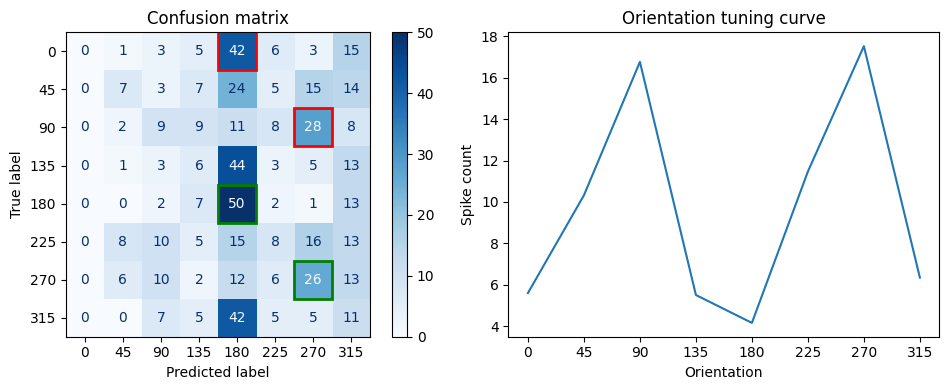

In [107]:
# create a confusion matrix
conf_mat = confusion_matrix(eval_nb['orientation'], eval_nb['pred_ori'])

# plot the confusion matrix
fig, ax = plt.subplots(1,2, figsize=(10,4))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=ori_vals)
cmd.plot(ax=ax[0],cmap='Blues')
ax[0].set_title('Confusion matrix')
ax[0].set_xticklabels(map(int,ori_vals))
ax[0].set_yticklabels(map(int,ori_vals))
# draw a red box around the square where the true label is 90 and the predicted label is 270
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==270)[0][0]-0.5, np.where(ori_vals==90)[0][0]-0.5), 1, 1, fill=False, edgecolor='red', lw=2))
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==270)[0][0]-0.5, np.where(ori_vals==270)[0][0]-0.5), 1, 1, fill=False, edgecolor='green', lw=2))
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==180)[0][0]-0.5, np.where(ori_vals==0)[0][0]-0.5), 1, 1, fill=False, edgecolor='red', lw=2))
ax[0].add_patch(plt.Rectangle((np.where(ori_vals==180)[0][0]-0.5, np.where(ori_vals==180)[0][0]-0.5), 1, 1, fill=False, edgecolor='green', lw=2))

ax[1].plot(ori_vals, rf_ori_mean[0])
ax[1].set_xticks(ori_vals)
ax[1].set_xlabel('Orientation')
ax[1].set_ylabel('Spike count')
ax[1].set_title('Orientation tuning curve')
fig.tight_layout()


At this point it might occur to you that since $p(x|y)=p(x,y)/p(y)$, and Bayes rule has us solve for $p(y|x) \propto p(x|y)p(y)$ to identify the most likely event $y$, that we are doing some uneccessary work. Those $p(y)$ terms cancel out and we get $p(x|y) \propto p(x,y)$. 

TypeError: 'Axes' object is not subscriptable

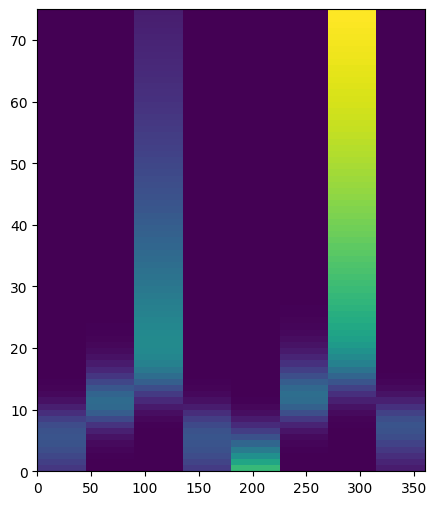

In [110]:
# fit a Poisson distribution based on the mean spike counts for each orientation
p_ygx_pois = p_xy_pois / np.sum(p_xy_pois,axis=1)[:,np.newaxis]

# plot the joint distribution and the Poisson fit
fig, ax = plt.subplots(figsize=(5,6))
ax.pcolormesh(x, y, p_ygx_pois)
fig.colorbar(ax=ax[0], mappable=ax[0].collections[0])
ax.set_xlabel('Orientation')
ax.set_ylabel('Spike count')
ax.set_title('Observed')